# **DATA EXTRACTION**

I'll begin by choosing the data I intend to use from the lending club data spanding from 2007 to 2020.

**RAN THIS FILE ON JUPYTER NOTEBOOK**

## **1. Load Data**

In [ ]:
# Import necessary libraries
!pip install xgboost
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, roc_auc_score)

In [ ]:
df = pd.read_csv('Loan_status_2007-2020Q3.gzip', low_memory=False)

In [ ]:
df

,Unnamed: 0,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
0,0,1077501,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
1,1,1077430,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
2,2,1077175,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
3,3,1076863,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
4,4,1075358,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2058658,190897,55111635,19200.0,19200.0,19200.0,60 months,12.29%,429.92,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
2058659,190898,56452878,8425.0,8425.0,8425.0,36 months,12.29%,281.00,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
2058660,190899,56643563,25500.0,25500.0,25500.0,36 months,18.55%,928.94,E,E2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
2058661,190900,56492487,14000.0,14000.0,14000.0,36 months,10.99%,458.28,B,B4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N


## **2. Visualise and Analyse Target Variable (loan_status) Distribution**

### **i. Loan status distribution across years**

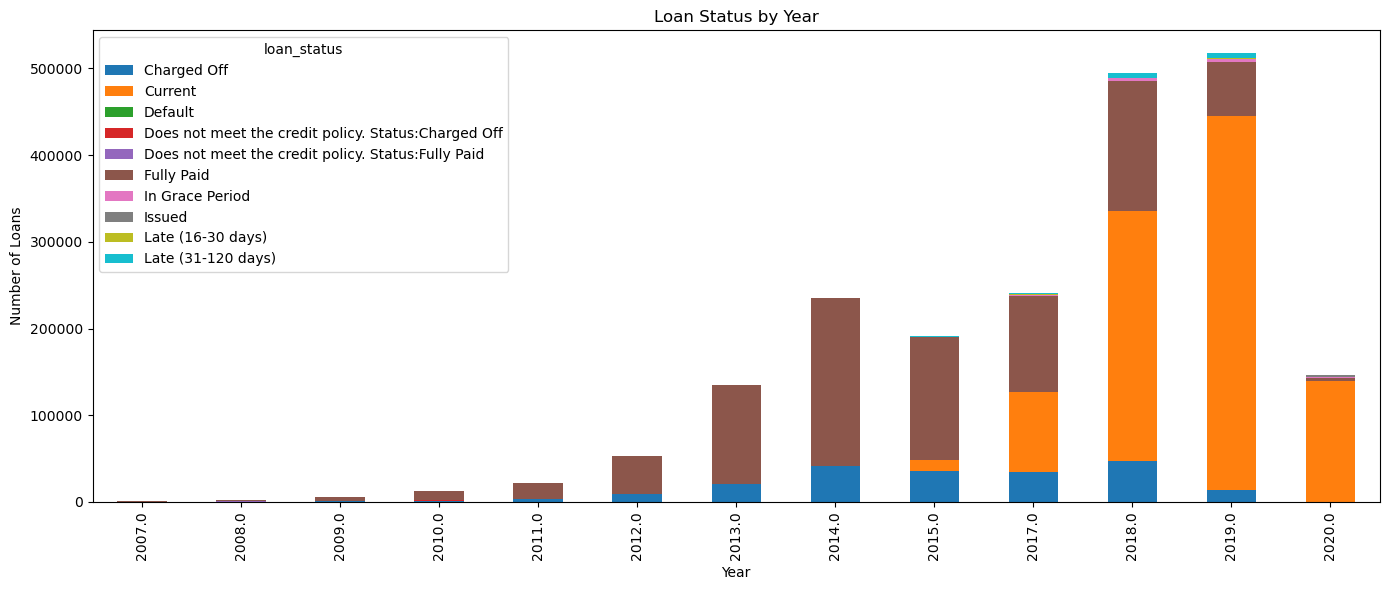

In [ ]:
# convert and extract year from issue date
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%Y', errors='coerce')
df['year'] = df['issue_d'].dt.year

# Group loan status by year
result = df.groupby(['year', 'loan_status']).size().unstack(fill_value=0)

# Plot
result.plot(kind='bar', stacked=True, figsize=(14,6))
plt.title('Loan Status by Year')
plt.xlabel('Year')
plt.ylabel('Number of Loans')
plt.tight_layout()
plt.show()


### **ii. Create a binary default variable from loan status**

In [ ]:
# Drop NaN values in 'loan_status' column
df = df.dropna(subset=['loan_status'])

# Define statuses
default_statuses = [
    "Charged Off",
    "Default",
    "Does not meet the credit policy. Status: Charged Off"
]

non_default_statuses = [
    "Fully Paid",
    "Does not meet the credit policy. Status: Fully Paid"
]

valid_statuses = default_statuses + non_default_statuses

# Keep only valid loan statuses
df = df[df['loan_status'].isin(valid_statuses)]

# Map to binary variable
df['default'] = df['loan_status'].apply(lambda x: 1 if x in default_statuses else 0)


### **iii. Loan default vs non-default counts by year**

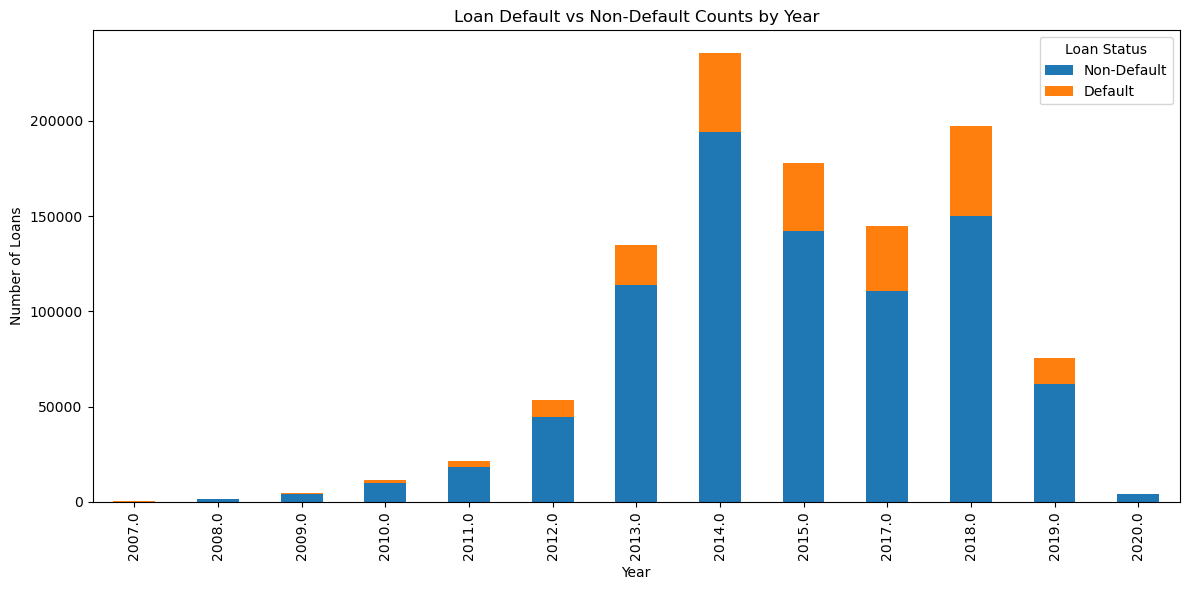

In [ ]:
# Group by year and default, then count
counts = df.groupby(['year', 'default']).size().unstack(fill_value=0)

# Rename columns for clarity
counts.columns = ['Non-Default', 'Default']

# Plot stacked bar chart
counts.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Loan Default vs Non-Default Counts by Year')
plt.xlabel('Year')
plt.ylabel('Number of Loans')
plt.legend(title='Loan Status')
plt.tight_layout()
plt.show()

### **iv. Percentage of loan defaults vs non-defaults by year**

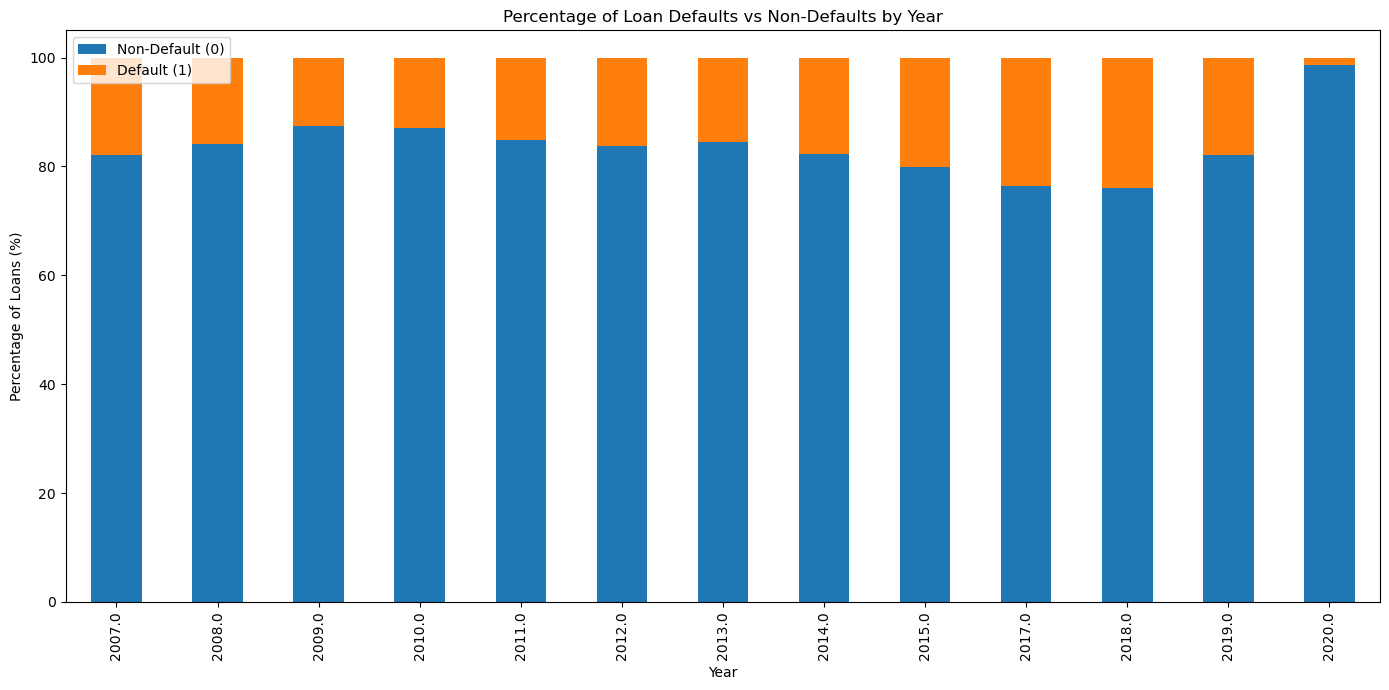

In [ ]:
# Group by year and default status, count occurrences
grouped = df.groupby(['year', 'default']).size().unstack(fill_value=0)

# Calculate percentage
percent = grouped.div(grouped.sum(axis=1), axis=0) * 100

# Plot percentage stacked bar chart
percent.plot(kind='bar', stacked=True, figsize=(14, 7))

plt.title('Percentage of Loan Defaults vs Non-Defaults by Year')
plt.xlabel('Year')
plt.ylabel('Percentage of Loans (%)')
plt.legend(['Non-Default (0)', 'Default (1)'])
plt.tight_layout()
plt.show()


### **v. Trend of Default and Non-Default Loans Over the Years**

In [ ]:
# Plot trend lines for defaults and non-defaults over the years
plt.figure(figsize=(12, 6))
plt.plot(counts.index, counts['Non-Default'], marker='o', label='Non-Default')
plt.plot(counts.index, counts['Default'], marker='o', label='Default')

plt.title('Trend of Loan Defaults and Non-Defaults Over Years')
plt.xlabel('Year')
plt.ylabel('Number of Loans')
plt.legend(title='Loan Status')
plt.grid(True)
plt.tight_layout()
plt.show()

### **vi. Tabular presentation of total loans, default, and non-default counts and percentages**

In [ ]:
# Group by year and default status, count occurrences
grouped = df.groupby(['year', 'default']).size().unstack(fill_value=0)

# Rename columns for clarity (assuming 0 = non-default, 1 = default)
grouped = grouped.rename(columns={0: 'non_default', 1: 'default'})

# Calculate total loans
grouped['total'] = grouped['non_default'] + grouped['default']

# Calculate default percentage
grouped['percent_default'] = (grouped['default'] / grouped['total']) * 100
grouped['percent_default'] = grouped['percent_default'].round(2)

# Reorder columns as requested
grouped = grouped[['total', 'non_default', 'default', 'percent_default']]

display(grouped)

## **3. STRATIFIED SAMPLING**

In [ ]:
exp = df.dropna(axis=1)

In [ ]:
xcld = ['issue_d', 'earliest_cr_line', 'url', 'id', 'loan_status', 'recoveries', 'collection_recovery_fee',
               'total_rec_late_fee', 'funded_amnt', 'funded_amnt_inv', 'total_rec_int',
               'policy_code', 'out_prncp_inv', 'out_prncp', 'last_fico_range_high', 'last_fico_range_low',
               'total_rec_prncp', 'last_pymnt_amnt', 'total_pymnt_inv', 'total_pymnt']

In [ ]:
exp = exp.drop(columns=xcld)

In [ ]:
# encode the categorical features
label_encoder = LabelEncoder()
for col in exp.columns:
    if exp[col].dtype == 'object':
        exp[col] = label_encoder.fit_transform(exp[col].astype(str))

**Sample Size 10%**

In [ ]:
sd_10, _ = train_test_split(exp, test_size=1-0.10, stratify=exp['default'])

print(f'Total size: {len(sd_10)}')

Total size: 106331


In [ ]:
X_10 = sd_10.drop(['default'], axis=1)
y_10 = sd_10['default']

In [ ]:
X_train_10, X_test_10, y_train_10, y_test_10 = train_test_split(X_10, y_10, test_size=0.20, random_state=42)

In [ ]:
xgb_model = XGBClassifier(random_state=42)

xgb_model.fit(X_train_10, y_train_10)
xgb_y_pred_proba = xgb_model.predict_proba(X_test_10)[:, 1]
xgb_y_pred = xgb_model.predict(X_test_10)

xgb_accuracy = accuracy_score(y_test_10, xgb_y_pred)
xgb_precision = precision_score(y_test_10, xgb_y_pred)
xgb_recall = recall_score(y_test_10, xgb_y_pred)
xgb_auc_roc = roc_auc_score(y_test_10, xgb_y_pred_proba)

print("XGBoost Classifier (10%):")
print(f"Accuracy: {xgb_accuracy:.4f}")
print(f"Precision: {xgb_precision:.4f}")
print(f"Recall: {xgb_recall:.4f}")
print(f"AUC-ROC: {xgb_auc_roc:.4f}")

XGBoost Classifier (10%):
Accuracy: 0.8050
Precision: 0.4976
Recall: 0.1004
AUC-ROC: 0.7071


In [ ]:
sd_10, _ = train_test_split(df, test_size=1-0.10, stratify=df['loan_status'], random_state=42)

sd_10.info()

<class 'pandas.core.frame.DataFrame'>
Index: 106331 entries, 1503551 to 1885090
Columns: 144 entries, Unnamed: 0 to default
dtypes: datetime64[ns](1), float64(107), int64(2), object(34)
memory usage: 117.6+ MB


**Sample Size 30%**

In [ ]:
sd_30, _ = train_test_split(exp, test_size=1-0.30, stratify=exp['default'])
print(f'Total size: {len(sd_30)}')

Total size: 318993


In [ ]:
X_30 = sd_30.drop(['default'], axis=1)
y_30 = sd_30['default']

In [ ]:
X_train_30, X_test_30, y_train_30, y_test_30 = train_test_split(X_30, y_30, test_size=0.20, random_state=42)

In [ ]:
xgb_model = XGBClassifier(random_state=42)

xgb_model.fit(X_train_30, y_train_30)
xgb_y_pred_proba = xgb_model.predict_proba(X_test_30)[:, 1]
xgb_y_pred = xgb_model.predict(X_test_30)

xgb_accuracy = accuracy_score(y_test_30, xgb_y_pred)
xgb_precision = precision_score(y_test_30, xgb_y_pred)
xgb_recall = recall_score(y_test_30, xgb_y_pred)
xgb_auc_roc = roc_auc_score(y_test_30, xgb_y_pred_proba)

print("XGBoost Classifier (30%):")
print(f"Accuracy: {xgb_accuracy:.4f}")
print(f"Precision: {xgb_precision:.4f}")
print(f"Recall: {xgb_recall:.4f}")
print(f"AUC-ROC: {xgb_auc_roc:.4f}")

XGBoost Classifier (30%):
Accuracy: 0.8057
Precision: 0.5100
Recall: 0.0865
AUC-ROC: 0.7126


In [ ]:
sd_30, _ = train_test_split(df, test_size=1-0.30, stratify=df['loan_status'], random_state=42)

sd_30.info()

<class 'pandas.core.frame.DataFrame'>
Index: 318993 entries, 1681053 to 1899098
Columns: 144 entries, Unnamed: 0 to default
dtypes: datetime64[ns](1), float64(107), int64(2), object(34)
memory usage: 352.9+ MB


**Sample Size 50%**

In [ ]:
sd_50, _ = train_test_split(exp, test_size=1-0.50, stratify=exp['default'])
print(f'Total size: {len(sd_50)}')

Total size: 531655


In [ ]:
X_50 = sd_50.drop(['default'], axis=1)
y_50 = sd_50['default']

In [ ]:
X_train_50, X_test_50, y_train_50, y_test_50 = train_test_split(X_50, y_50, test_size=0.20, random_state=42)

In [ ]:
xgb_model = XGBClassifier(random_state=42)

xgb_model.fit(X_train_50, y_train_50)
xgb_y_pred_proba = xgb_model.predict_proba(X_test_50)[:, 1]
xgb_y_pred = xgb_model.predict(X_test_50)

xgb_accuracy = accuracy_score(y_test_50, xgb_y_pred)
xgb_precision = precision_score(y_test_50, xgb_y_pred)
xgb_recall = recall_score(y_test_50, xgb_y_pred)
xgb_auc_roc = roc_auc_score(y_test_50, xgb_y_pred_proba)

print("XGBoost Classifier (50%):")
print(f"Accuracy: {xgb_accuracy:.4f}")
print(f"Precision: {xgb_precision:.4f}")
print(f"Recall: {xgb_recall:.4f}")
print(f"AUC-ROC: {xgb_auc_roc:.4f}")

XGBoost Classifier (50%):
Accuracy: 0.8067
Precision: 0.5438
Recall: 0.0881
AUC-ROC: 0.7185


In [ ]:
sd_50, _ = train_test_split(df, test_size=1-0.50, stratify=df['loan_status'], random_state=42)

sd_50.info()

<class 'pandas.core.frame.DataFrame'>
Index: 531655 entries, 67708 to 304836
Columns: 144 entries, Unnamed: 0 to default
dtypes: datetime64[ns](1), float64(107), int64(2), object(34)
memory usage: 588.1+ MB


**Total sample**

In [ ]:
X = exp.drop(['default'], axis=1)
y = exp['default']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
xgb_model = XGBClassifier(random_state=42)

xgb_model.fit(X_train, y_train)
xgb_y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
xgb_y_pred = xgb_model.predict(X_test)

xgb_accuracy = accuracy_score(y_test, xgb_y_pred)
xgb_precision = precision_score(y_test, xgb_y_pred)
xgb_recall = recall_score(y_test, xgb_y_pred)
xgb_auc_roc = roc_auc_score(y_test, xgb_y_pred_proba)

print("XGBoost Classifier (100%):")
print(f"Accuracy: {xgb_accuracy:.4f}")
print(f"Precision: {xgb_precision:.4f}")
print(f"Recall: {xgb_recall:.4f}")
print(f"AUC-ROC: {xgb_auc_roc:.4f}")

XGBoost Classifier (100%):
Accuracy: 0.8087
Precision: 0.5595
Recall: 0.0867
AUC-ROC: 0.7207


**Chosen sample size**

In [ ]:
sample_size = 0.30

In [ ]:
sd, _ = train_test_split(df,
                         test_size=1-sample_size,
                         stratify=df['default'],
                         random_state=42)

In [ ]:
print(f"Sampling {sample_size * 100}% of the data:\nData: {len(df)} rows \nSample Size: {len(sd)} rows")

Sampling 30.0% of the data:
Data: 1063310 rows 
Sample Size: 318993 rows


In [ ]:
sd.info()

<class 'pandas.core.frame.DataFrame'>
Index: 318993 entries, 2026846 to 257396
Columns: 144 entries, Unnamed: 0 to default
dtypes: datetime64[ns](1), float64(107), int64(2), object(34)
memory usage: 352.9+ MB


In [ ]:
sd.shape

(318993, 144)

In [ ]:
sd['default'].value_counts()

default
0    256626
1     62367
Name: count, dtype: int64

In [ ]:
sd.to_csv('sd_30.csv', index = False)